## Setup

In [1]:
import numpy as np
import os
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = os.getcwd()

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## IRIS dataset

#### Use the iris datasets in sklearn, a quick SVC fit without data scaler will lead to a bad model.

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Saving figure large_margin_classification_plot


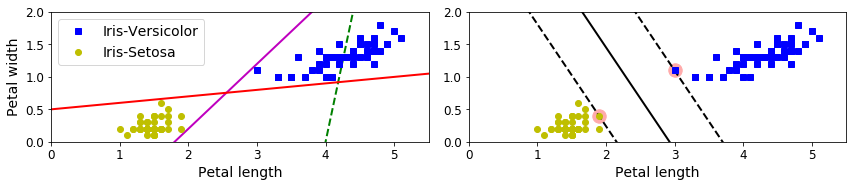

In [3]:
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

Saving figure sensitivity_to_outliers_plot


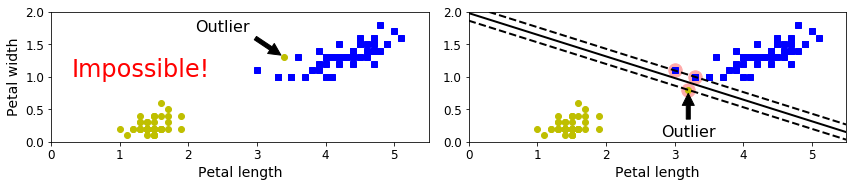

In [4]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

#### Use standard scaler and linear SVC instead of SVC with linear kernel, which is faster

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

#### Comparison of linearSVC, SVC with linear kernel, and a SGD classifier

In [6]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [7]:
from sklearn.linear_model import SGDClassifier
from time import time
C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=100000, tol=-np.infty, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

start_time=time() 
lin_clf.fit(X_scaled, y)
t1=time()-start_time 
start_time=time() 
svm_clf.fit(X_scaled, y)
t2=time()-start_time 
start_time=time() 
sgd_clf.fit(X_scaled, y)
t3=time()-start_time 
print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_, 'time: ', t1)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_, 'time: ', t2)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_, 'time: ', t3)

LinearSVC:                    [0.28481447] [[1.05541976 1.09851597]] time:  0.000993967056274414
SVC:                          [0.31933577] [[1.1223101  1.02531081]] time:  0.0009968280792236328
SGDClassifier(alpha=0.00200): [0.32] [[1.12293103 1.02620763]] time:  0.4064209461212158


#### Dataset is too small and cannot see differences of the linearSVC and SVC. But we can see that SGD take much more time than others. Interesting, the linearSVC did not get the same result as SVC.

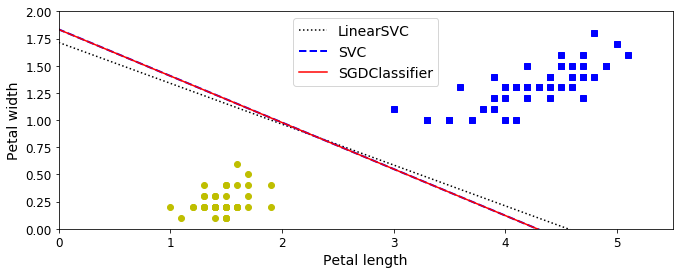

In [8]:
# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris-Versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris-Setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

#### They all get a similar boundary. Therefore, to determine which is better requires a more complex dataset

## MNIST dataset

In [9]:
import scipy.io
mnist = scipy.io.loadmat('mnist-original.mat')
mnist['data']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
# Shuffle the instances
X, y = mnist["data"].transpose(), mnist["label"].transpose().ravel()

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]


y_test = y[60000:]
np.random.seed(42)
rnd_idx = np.random.permutation(60000)
X_train = X_train[rnd_idx]
y_train = y_train[rnd_idx]

#### SVC is a binary classifier and we need one versus all methods to classify digits of 0 to 9 instead of training 45 one versus one classifiers

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [12]:
svm_clf = SVC(decision_function_shape="ovr", gamma="auto")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
from sklearn.metrics import accuracy_score

y_pred = svm_clf.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.943

#### The accuracy looks pretty good, just try a random grid search to see if can further improve the behavior. A smaller dataset is used to save time to find the best parameters.

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................
[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   1.0s
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   1.0s
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................
[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   1.0s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   1.2s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   1.2s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   1.2s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .. C=9.875199193765326, gamma=0.051349833451870636, total=   1.4s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .. C=9.875199193765326, gamma=0.051349833451870636, total=   1.3s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   55.3s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029D6CDB6C18>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029D6CDB66D8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [17]:
rnd_search_cv.best_estimator_

SVC(C=8.852316058423087, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001766074650481071,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [18]:
rnd_search_cv.best_score_

0.856

#### Small dataset lead to a poor behavior of 0.856. But we can  use the same parameter to the whole train set  and can obtain a great improvement.

In [19]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=8.852316058423087, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001766074650481071,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [20]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9709